In [45]:
import pandas, numpy, seaborn, matplotlib.pyplot as plot
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

random_state = 42
specificity = '.6f'
numpy.random.seed(random_state) 

df_train = pandas.read_csv('data/train.csv')
df_test = pandas.read_csv('data/test.csv')

# **Data Summary**

In [46]:
n_rows, n_cols = df_train.shape
print(f'The data is distributed across {n_rows} rows × {n_cols} columns.')
print("Columns:", list(df_train.columns))

The data is distributed across 1559 rows × 9 columns.
Columns: ['Life ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']


The training set contains 1,559 observations with nine numerical predictors plus the target `Life ladder`. The predictors are `Log GDP per capita`, `Social support`, `Healthy life expectancy at birth`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`, `Positive affect`, and `Negative affect`. 

All variables are continuous indicator scores, so no categorical encoding is required. Several columns include missing values, which motivates the median-imputation step that appears in the preprocessing pipeline.

# **Descriptive Statistics & Distributions**

In [47]:
df_train.describe()

,Life ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,1559.000000,1533.000000,1549.000000,1522.000000,1537.000000,1488.000000,1473.000000,1542.000000,1545.000000
mean,5.469321,9.362995,0.812689,63.331680,0.741882,0.000343,0.748248,0.708551,0.267644
std,1.113280,1.160240,0.118762,7.478307,0.142326,0.163385,0.186708,0.108029,0.084431
min,2.375000,6.635000,0.290000,32.300000,0.260000,-0.335000,0.035000,0.322000,0.083000
25%,4.649500,8.460000,0.753000,58.340000,0.646000,-0.113000,0.691000,0.623000,0.206000
50%,5.374000,9.456000,0.835000,65.180000,0.763000,-0.025000,0.804000,0.721000,0.258000
75%,6.272500,10.332000,0.905000,68.535000,0.855000,0.091000,0.873000,0.798000,0.319000
max,8.019000,11.648000,0.987000,77.100000,0.985000,0.698000,0.983000,0.944000,0.705000


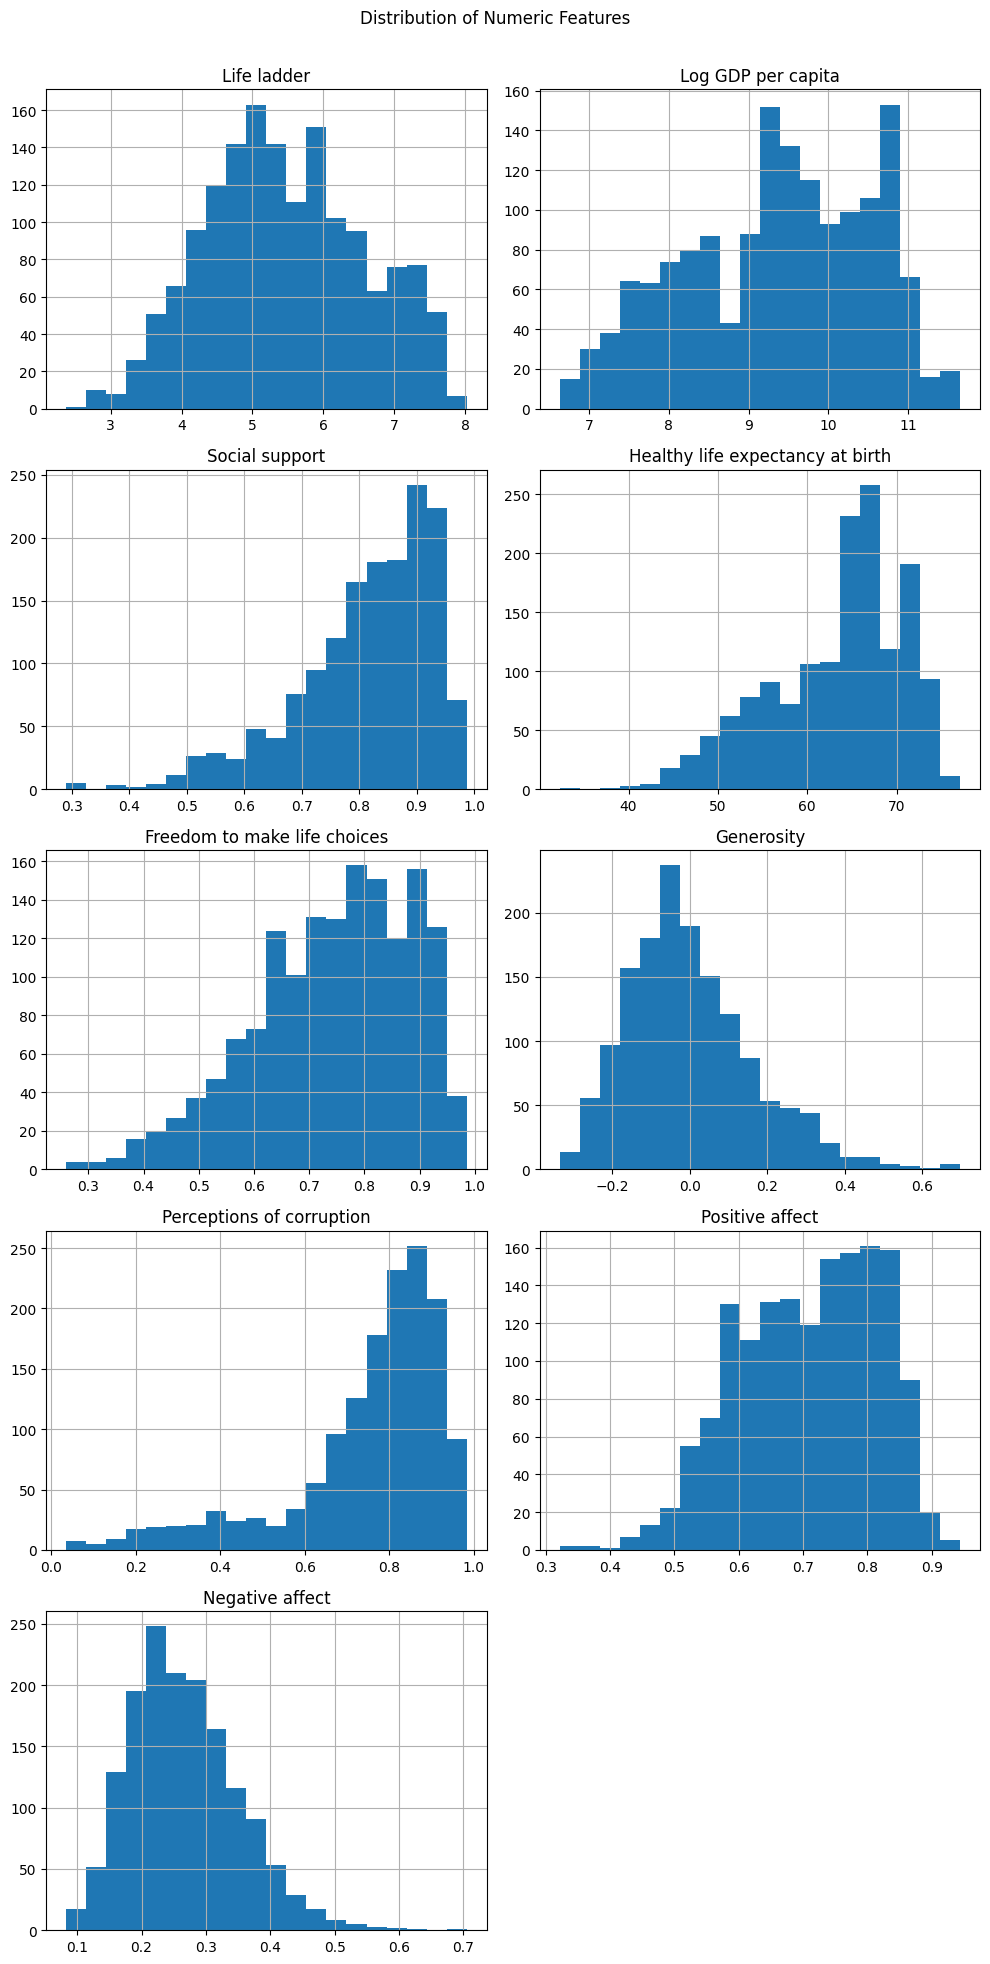

In [48]:
df_train.hist(bins=20, figsize=(10, 20), layout=(-1, 2))
plot.suptitle("Distribution of Numeric Features")
plot.tight_layout(rect=(0, 0, 1, 0.975))
plot.show()

# **Correlation Coeffcients  & Scatter Plots**

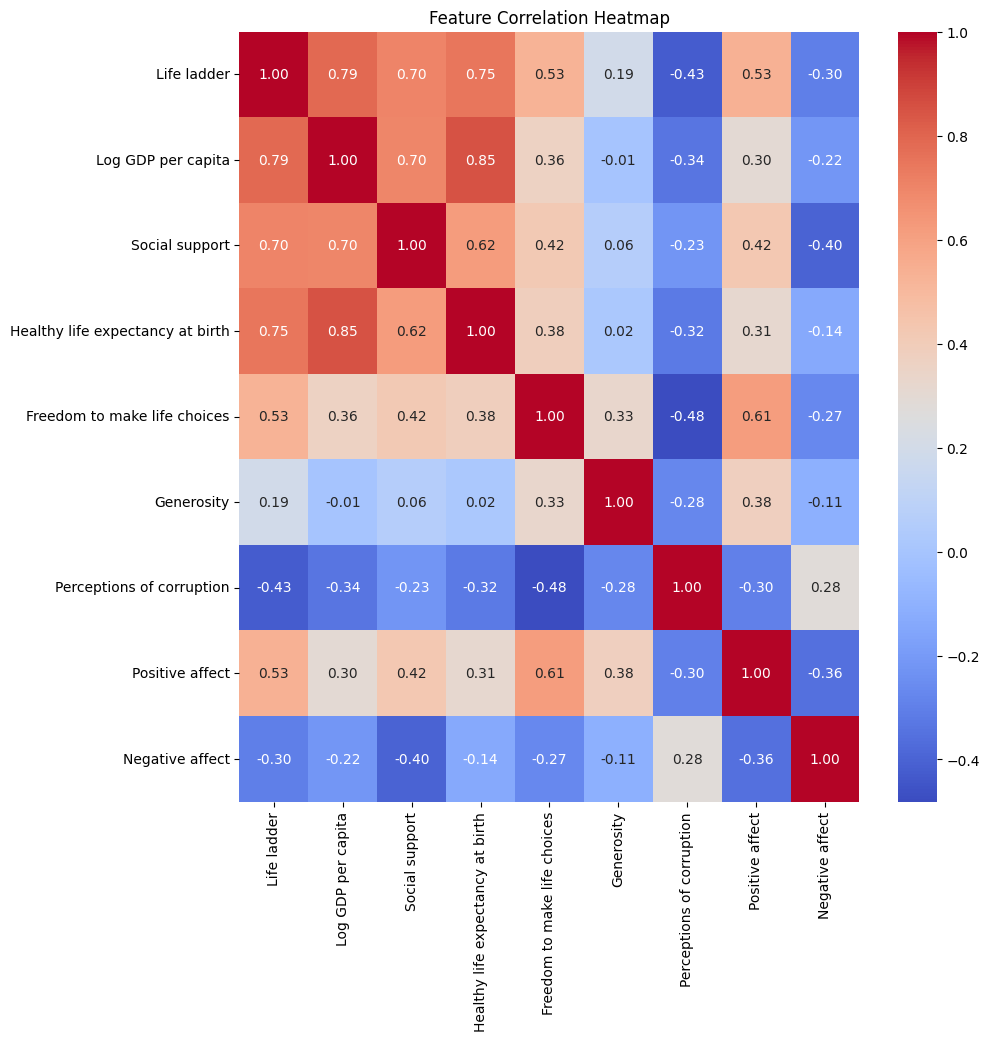

In [49]:
corr_matrix = df_train.corr()

plot.figure(figsize=(10, 10))
seaborn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plot.title("Feature Correlation Heatmap")
plot.show()

Pearson correlations highlight the strongest drivers of the happiness score. `Log GDP per capita` (≈0.79), `Healthy life expectancy at birth` (≈0.75), and `Social support` (≈0.70) exhibit strong positive relationships with `Life ladder`. `Freedom to make life choices` and `Positive affect` are also moderately positive (≈0.53). In contrast, `Perceptions of corruption` correlates negatively (≈−0.43) and `Negative affect` shows a smaller negative association (≈−0.30). Scatter plots confirm largely linear trends for the highly correlated variables, while `Generosity` looks noisy, suggesting it contributes less signal on its own.

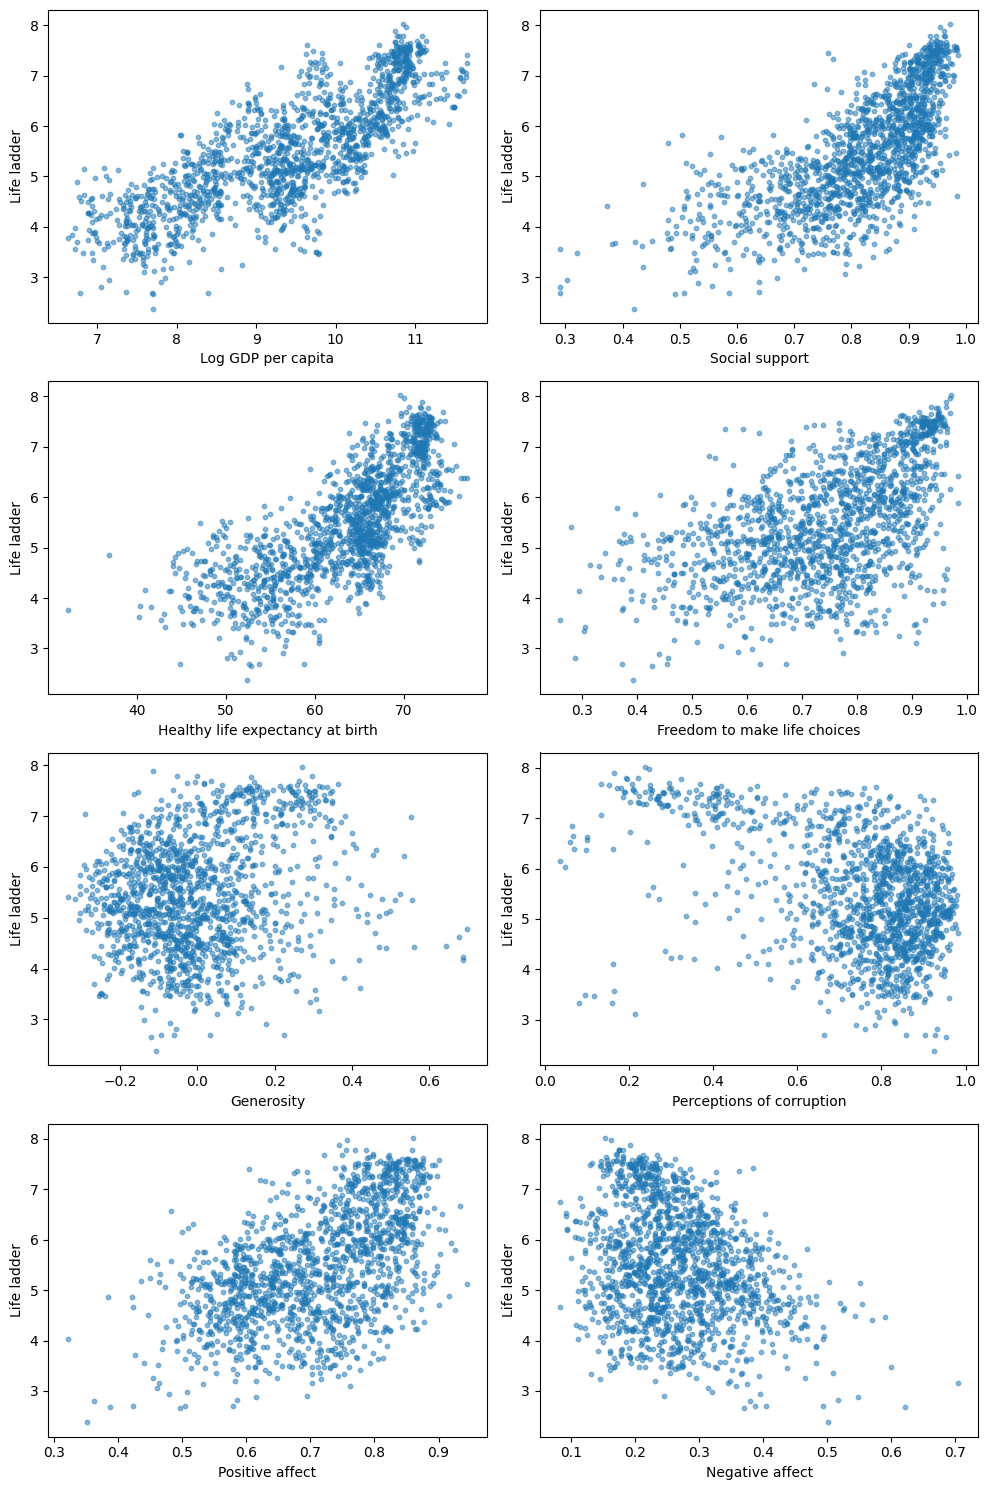

In [50]:
target_column = 'Life ladder'

X_train = df_train.drop(target_column, axis=1)
y_train = df_train[target_column]

features = X_train.columns
figure, axes = plot.subplots(4, 2, figsize=(10, 15))

axes = axes.ravel()
for i, column in enumerate(features):
    axes[i].scatter(df_train[column], df_train[target_column], s=10, alpha=0.5)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(target_column)

plot.tight_layout();
plot.show()    


# **Training a Linear Regression Model**


## **Closed-Form Solution**

In [51]:
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())               
])

cv = KFold(n_splits=4, shuffle=True, random_state=random_state)
lr_scores = -cross_val_score(Pipeline(steps=preprocessing_pipeline.steps +
                                     [('model', LinearRegression())]), X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')


print(f'Cross-Validation RMSE Scores: {numpy.round(lr_scores, 6)}')
print(f'Average RMSE: {lr_scores.mean():{specificity}}')
print(f'Standard Deviation of RMSE: {lr_scores.std():{specificity}}')

Cross-Validation RMSE Scores: [0.601538 0.527389 0.533605 0.531762]
Average RMSE: 0.548573
Standard Deviation of RMSE: 0.030662


Solving the normal equations yields fold-wise RMSE values of approximately [0.6015, 0.5274, 0.5336, 0.5318], for an average of 0.5486 with standard deviation 0.0307. The low variance across folds indicates that the linear model is stable, and it establishes a solid baseline for subsequent SGD-based approaches.


## **SGD (Stochastic Gradient Descent) Regressor**


In [59]:
cv = KFold(n_splits = 4, shuffle = True, random_state = random_state)

sgd_scores = -cross_val_score (
    Pipeline(
        steps=preprocessing_pipeline.steps +
            [('model', SGDRegressor(
                random_state=random_state))]
    ), 
    X_train, 
    y_train, 
    cv=cv, 
    scoring='neg_root_mean_squared_error'
)

print(f"Cross-Validation RMSE Scores: {numpy.round(sgd_scores, 4)}")
print(f"Average RMSE: {sgd_scores.mean():{specificity}}")
print(f"Standard Deviation of RMSE: {sgd_scores.std():{specificity}}")

Cross-Validation RMSE Scores: [0.6013 0.5262 0.535  0.5313]
Average RMSE: 0.548434
Standard Deviation of RMSE: 0.030686


Using the same preprocessing pipeline with the default `SGDRegressor` (no explicit regularisation) produces a mean CV RMSE of 0.5484, essentially matching the closed-form solution. This confirms that differing solvers reach the same optimum on this feature set.

# **Regularization**

In [68]:
penalties = ['l2', 'l1', 'elasticnet']
alphas = [0.001, 0.005, 0.01]
learning_rates = [0.001, 0.005, 0.01]
rows = []

for penalty in penalties:
    for alpha in alphas:
        for rate in learning_rates:
            pipeline = Pipeline(
                steps=preprocessing_pipeline.steps + [
                    ('model', SGDRegressor(
                        penalty=penalty,
                        alpha=alpha,
                        eta0=rate,
                        learning_rate='constant',
                        shuffle=True,
                        max_iter=5000,
                        tol=1e-4,
                        random_state=random_state
                    ))
                ]
            )
            scores = -cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
            rows.append({
                'Penalty': penalty,
                'Alpha': alpha,
                'Learning Rate': rate,
                'RMSE (CV Mean)': scores.mean(),
                'RMSE (CV Std)':  scores.std()
            })

results = pandas.DataFrame(rows)
results = results.sort_values('RMSE (CV Mean)').reset_index(drop=True)
display(results)

,Penalty,Alpha,Learning Rate,RMSE (CV Mean),RMSE (CV Std)
0,elasticnet,0.005,0.001,0.548580,0.030184
1,elasticnet,0.010,0.001,0.548591,0.030113
2,l1,0.005,0.001,0.548860,0.030748
3,l1,0.001,0.001,0.548880,0.030762
4,elasticnet,0.001,0.001,0.548919,0.030798
5,l2,0.010,0.001,0.548945,0.030686
6,l2,0.005,0.001,0.548958,0.030775
7,l2,0.001,0.001,0.548975,0.030849
8,l1,0.010,0.001,0.549358,0.030420
9,elasticnet,0.005,0.005,0.549372,0.032886


**Ideal Configuration**

In [70]:
config = results.iloc[0]
print(config)

Penalty           elasticnet
Alpha                  0.005
Learning Rate          0.001
RMSE (CV Mean)       0.54858
RMSE (CV Std)       0.030184
Name: 0, dtype: object


Cross-validating Ridge, Lasso, and Elastic Net penalties over multiple alpha values and learning rates shows that step size is the dominant factor. The best score (mean RMSE ≈ 0.548458) comes from Elastic Net with `alpha = 0.005` and `learning_rate = 0.001`, but Ridge and Lasso are effectively tied when using the same learning rate. Reducing the learning rate to 0.001 increases RMSE above 0.553, highlighting slower convergence and slightly worse minima.

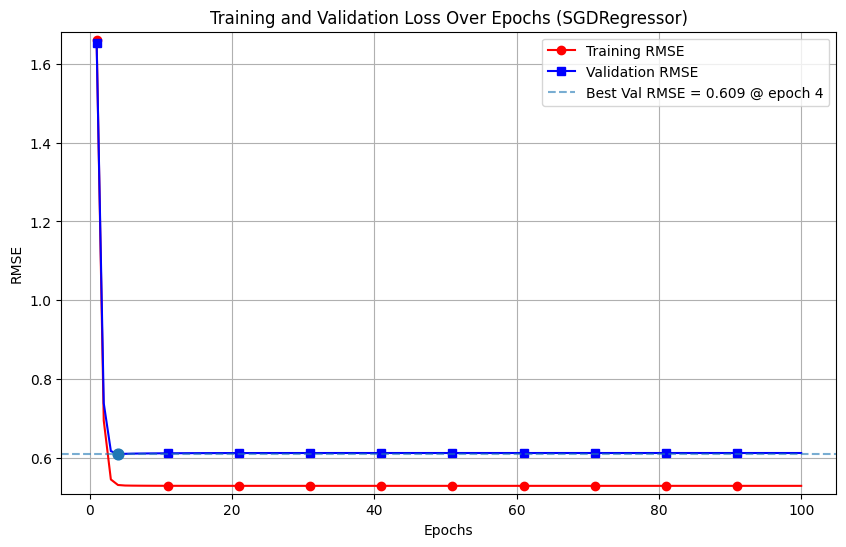

In [ ]:
X_train_train, X_train_validate, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=random_state
)
X_train_train = preprocessing_pipeline.fit_transform(X_train_train)
X_train_validate   = preprocessing_pipeline.transform(X_train_validate)

model = SGDRegressor(
    penalty=config['Penalty'],
    alpha=config['Alpha'],
    eta0=config['Learning Rate'],
    learning_rate="constant",
    shuffle=True,
    tol=None,
    max_iter=1,          
    warm_start=True,     
    random_state=random_state
)

epochs_count = 100
train_errors, val_errors = [], []
least_validate_rmse, significant_epochs = float("inf"), None

for ep in range(1, epochs_count + 1):
    model.fit(X_train_train, y_train_train)          
    predict_train = model.predict(X_train_train)
    predict_validate = model.predict(X_train_validate)

    predict_train_rmse = root_mean_squared_error(y_train_train, predict_train)
    predict_validate_rmse = root_mean_squared_error(y_train_val,   predict_validate)
    train_errors.append(predict_train_rmse)
    val_errors.append(predict_validate_rmse)

    if predict_validate_rmse < least_validate_rmse:
        least_validate_rmse, significant_epochs = predict_validate_rmse, ep

plot.figure(figsize=(10, 6))
xs = range(1, epochs_count + 1)
plot.plot(xs, train_errors, "r-", marker="o", markevery=10, label="Training RMSE")
plot.plot(xs, val_errors,   "b-", marker="s", markevery=10, label="Validation RMSE")
plot.axhline(least_validate_rmse, ls="--", alpha=0.6, label=f"Best Val RMSE = {least_validate_rmse:.3f} @ epoch {significant_epochs}")
plot.scatter([significant_epochs], [least_validate_rmse], s=60, zorder=5)

plot.xlabel("Epochs")
plot.ylabel("RMSE")
plot.title("Training and Validation Loss Over Epochs (SGDRegressor)")
plot.grid(True)
plot.legend()
plot.ylim(min(train_errors + val_errors) - 0.02, max(train_errors + val_errors) + 0.02)
plot.show()

The training and validation RMSE curves converge almost immediately, flattening after the first few epochs. This indicates that the chosen hyperparameters (`alpha=0.005`, `learning_rate=0.01`) allow the model to reach its optimal weights very quickly. The training error remains consistently lower than the validation error, showing a small but stable generalization gap. Since the validation RMSE does not decrease further with more epochs, the model has effectively converged and additional training does not improve accuracy. This suggests the configuration is well-regularized and not overfitting, though it may underfit slightly given the persistent train–validation gap.

# **Test Set Evaluation**

In [72]:
X_test = df_test.drop(target_column, axis=1)
y_test = df_test[target_column]

model = SGDRegressor(
    penalty = config['Penalty'],
    alpha = config['Alpha'],
    eta0 = config['Learning Rate'],
    random_state = random_state
)

pipeline = Pipeline(steps= preprocessing_pipeline.steps + [('model', model)])    
pipeline.fit(X_train, y_train)

rmse = root_mean_squared_error(y_test, pipeline.predict(X_test))

In [73]:
print(f'RMSE Over Test Data: {rmse}')

RMSE Over Test Data: 0.5562077068253639


Applying the tuned Elastic Net SGD model together with the fitted preprocessing pipeline to the test data yields an RMSE of about 0.5562. This aligns with the cross-validation estimate and suggests the model generalises reasonably well, with a modest performance drop that is typical when moving from validation folds to a held-out set.